In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.io import fits
from astropy.utils.data import download_file

import sys
import os
import cv2

In [62]:
import sys
sys.path.append('./satmetrics') 

In [63]:
import line_detection_updated as ld
#from photutils.background import Background2D

import image_rotation as ir

In [64]:
import pixelplot

In [65]:
def load_decam_image(expnum, detector):
    """
    Load a  DECam image given the exposure number (expnum) and detector number (HDU).
    """
    natroot = 'https://astroarchive.noirlab.edu'
    adsurl = f'{natroot}/api/adv_search'

    jj = {
        "outfields": ["md5sum", "archive_filename", "EXPNUM"],
        "search": [
            ["instrument", "decam"],
            ["proc_type", "instcal"],
            ["EXPNUM", expnum, expnum],
            ["prod_type", "image"],
        ]
    }

    apiurl = f'{adsurl}/find/?limit=1'
    data = requests.post(apiurl, json=jj).json()

    if len(data) < 2:
        raise ValueError(f"No se encontró ninguna imagen para expnum {expnum}")

    query_result = data[1]
    md5sum = query_result['md5sum']

    access_url = f'{natroot}/api/retrieve/{md5sum}/?hdus={detector}'
    filename = download_file(access_url, cache=True)

    hdu_list = fits.open(filename)
    image = hdu_list[1].data
    header = hdu_list[1].header

    header_expnum = hdu_list[0].header

    return image, header, header_expnum

In [66]:
def plot_decam_image(image, expnum=None, detector=None):
    """
    Displays a DECam image using matplotlib, with some basic contrast scaling 
    and optional labels for exposure number and detector.
    """
    # Compute contrast limits using percentiles
    vmin = np.percentile(image, 5)
    vmax = np.percentile(image, 95)

    # Transpose for better visual orientation
    img = np.flip(image.T)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    
    title = "DECam Image"
    if expnum is not None and detector is not None:
        title += f" — expnum {expnum}, detector {detector}"
    elif expnum is not None:
        title += f" — expnum {expnum}"
    elif detector is not None:
        title += f" — detector {detector}"
    
    plt.title(title, fontsize=14)
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [102]:
def detect_lines_hough(image, threshold=0.075, flux_prop_thresholds=[0.1,0.2,0.3,1], 
                       blur_kernel_sizes=[3,5,9,11], brightness_cuts=(2,2), thresholding_cut=0.5 ,**kwargs):

    """
    Applies Hough Transform line detection on a DECam image using the custom satmetrics module.

    Parameters:
        image (ndarray): 2D image array.
        **kwargs: Optional keyword arguments to pass into the LineDetection object (e.g. thresholds).
    """
    lineDetector = ld.LineDetection(image)
    lineDetector.threshold = threshold
    lineDetector.flux_prop_thresholds = flux_prop_thresholds
    lineDetector.blur_kernel_sizes = blur_kernel_sizes
    lineDetector.brightness_cuts = brightness_cuts
    lineDetector.thresholding_cut = thresholding_cut
    
    #lineDetector.threshold = 0.012 it could break the threshold
    for key, value in kwargs.items():
        setattr(lineDetector, key, value)

    # Hough transform
    detections = lineDetector.hough_transformation()
    return detections

In [103]:
def rotate_streak_horizontal(image, lines):
    """
    Rotates the image so that the main detected streak (line) is horizontal.
    
    """
    if lines is None or len(lines) == 0:
        raise ValueError("No lines detected to use for rotation.")
    
    line = lines[0]
    coords = [[line[0], line[1]], [line[2], line[3]]]
    angle = ir.determine_rotation_angle(coords)
    rotated_image = ir.rotate_image(image, angle, coords)
    
    return rotated_image, coords, angle

In [104]:
#expnum = 1033925  
#detector =  17 

#full_ccd_image_data, header, header_expnum = load_decam_image(expnum, detector)

In [105]:
#if image_data is not None:
#    plot_decam_image(full_ccd_image_data, expnum=expnum, detector=detector)

In [106]:
def get_rotated_streak_image (full_ccd_image_data, **kwargs):
 
    detected_lines = detect_lines_hough(full_ccd_image_data, **kwargs)
   
                
    plt.imshow(detected_lines['Thresholded Image'])
    plt.imshow(detected_lines['Edges'])
    clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"], detected_lines["Lines"])

    #for k, v in detected_lines.items():
    #    print(k, len(v))
    rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])
    pixelplot.pixelplot(rotated_images[0])
    return rotated_images[0]

In [99]:


def streak_photometry_psf_fitting (image_data, header, header_two, pdf=None):
    """
    simulation = True 
    pixel_scale = 0.2637 # DECAm plate scale at the center
    if simulation:
        sim_filename = "simulated_psf_convolved_trail.txt"
        image_data = np.loadtxt(sim_filename)
        #From simulated streak
        gain = 3.95                      # e-/ADU
        read_noise = 6.0
        sigma_bad_pixel_mask = 10  # No bad pixels in sims, so use high threshold
    else:
        # For expnum 1103448, detector 26!
        image_data = np.loadtxt("sample_image.txt")
        header = {
            "GAINA": 3.95321314938068,
            "GAINB": 3.95211128886414,
            "RDNOISEA": 5.747898,
            "RDNOISEB": 5.928192
        }
        gain = 0.5 * (header["GAINA"] + header["GAINB"])
        read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])
        
        sigma_bad_pixel_mask = 3
    """

    gain = 0.5 * (header["GAINA"] + header["GAINB"])
    read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])
    print ("average amp gain (e/ADU)", gain)
    print ("average read noise (e)", read_noise)

    if 'MAGZERO' in header_two:
        zero_point = header_expnum['MAGZERO']
        print ("zero point [mag]: ", zero_point)
    else:
        print ("No MAGZERO keyword in header")
        zero_point = None
    
    # Build a simple bad pixel mask
    sigma_bad_pixel_mask = 3
    median = np.median(image_data)
    std = np.std(image_data)
    threshold = median + sigma_bad_pixel_mask * std
    bp_mask = image_data > threshold
    
    
    ny, nx = image_data.shape
    x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny))
    x_flat = x_grid.ravel()
    y_flat = y_grid.ravel()
    z_flat = image_data.ravel()
    mask_flat = bp_mask.ravel()
    
    # Apply mask: exclude masked pixels from fitting
    x_flat = x_flat[~mask_flat]
    y_flat = y_flat[~mask_flat]
    z_flat = z_flat[~mask_flat]
    
    
    # === Trail model: θ is free ===
    def trail_model(coords, b, phi, L, sigma, theta, x0, y0):
        x, y = coords
        sin_t = np.sin(theta)
        cos_t = np.cos(theta)
        x_rot = (x - x0) * sin_t + (y - y0) * cos_t
        Q = (x - x0) * cos_t - (y - y0) * sin_t
        term1 = b
        term2 = (phi / L) * (1 / (2 * sigma * np.sqrt(2 * np.pi)))
        term3 = np.exp(- (x_rot ** 2) / (2 * sigma ** 2))
        erf1 = (Q + L/2) / (sigma * np.sqrt(2))
        erf2 = (Q - L/2) / (sigma * np.sqrt(2))
        return term1 + term2 * term3 * (erf(erf1) - erf(erf2))
    
    # === Initial guess and bounds ===
    b0 = np.median(image_data)
    phi0 = np.sum(image_data) - b0 * image_data.size
    L0 = 2000
    sigma0 = 1.0
    theta0 = 0.0
    x0_0 = nx / 2
    y0_0 = ny / 2
    p0 = [b0, phi0, L0, sigma0, theta0, x0_0, y0_0]
    
    bounds = ([0, 0, 5, 0.3, -np.pi, 0, 0], [1e9, 1e9, 1e4, 10, np.pi, nx-1, ny-1])
    
    # === Fit ===
    popt, pcov = curve_fit(trail_model, (x_flat, y_flat), z_flat, p0=p0, bounds=bounds, maxfev=5000)
    b_fit, phi_fit, L_fit, sigma_fit, theta_fit, x0_fit, y0_fit = popt
    phi_err = np.sqrt(np.diag(pcov))[1]
    
    # === Reconstruct model ===
    model_image = trail_model((x_grid, y_grid), *popt)
    
    # Approximate trail aperture mask using rotated bounding box
    coords_x = x_grid - x0_fit
    coords_y = y_grid - y0_fit
    cos_t = np.cos(theta_fit)
    sin_t = np.sin(theta_fit)
    q = coords_x * cos_t + coords_y * sin_t   # along-trail
    r = coords_x * sin_t - coords_y * cos_t   # cross-trail
    
    # Another mask, for the chi2
    mask = ((np.abs(q) < length / 2) & (np.abs(r) < width / 2)) & ~bp_mask
    ap_data = image_data[mask]
    ap_model = model_image[mask]
    ap_N = np.sum(mask)
    
    # === Chi² and reduced Chi² ===
    noise_var = (gain * ap_model + read_noise**2) / gain**2
    chi2 = np.sum((ap_data - ap_model)**2 / noise_var)
    chi2_red = chi2 / (ap_N - 7 - 1)
    
    # === S/N from section 3 near Eq. 8: S / sqrt(S + B)
    S = phi_fit
    B = b_fit * ap_N
    SNR = S / np.sqrt(S + B)
    
    # === Surface brightness ===
    # area_arcsec2 = ap_N * pixel_scale**2
    psf_fwhm_arcsec = 2.355 * sigma_fit * pixel_scale
    area_arcsec2 = L_fit * pixel_scale * psf_fwhm_arcsec
    
    sb_arcsec2 = S / area_arcsec2
    sb_arcsec2_err = phi_err / area_arcsec2
    
    # === Print results ===
    print("\n=== Trail Fit Results (θ free) ===")
    print(f"Background: {b_fit:.2f} counts/pixel")
    print(f"Total flux (phi): {phi_fit:.2f} ± {phi_err:.2f} ADU")
    print(f"Trail length (L): {L_fit:.2f} px")
    print(f"PSF sigma: {sigma_fit:.2f} px → FWHM = {2.355 * sigma_fit:.2f} px --> {2.355 * sigma_fit*pixel_scale:.2f} arcsec ")
    print(f"Trail angle θ: {np.degrees(theta_fit):.2f} deg")
    print(f"Center: x0 = {x0_fit:.2f}, y0 = {y0_fit:.2f}")
    print(f"Surface brightness: {sb_arcsec2:.2f} ± {sb_arcsec2_err:.2f} counts/arcsec²")
    print(f"S/N (section 3): {SNR:.1f}")
    print(f"Chi²: {chi2:.2f}")
    print(f"Reduced Chi²: {chi2_red:.4f}")

    if zero_point: 
        sb_mag_arcsec2 = zero_point - 2.5 * np.log10(sb_arcsec2)
        # Approximate the error as the inverse of SNR
        sb_mag_arcsec2_err = 1.0857 / SNR
    
        # Output
        print(f"\nSurface brightness (mag/arcsec²): {sb_mag_arcsec2:.2f} ± {sb_mag_arcsec2_err:.4f}")
        print(f"Signal-to-noise ratio (SNR): {SNR:.1f}")
    else:
        print ("Image with no zero point, can't convert to magnitude")
        sb_mag_arcsec2, sb_mag_arcsec2_err = None, None


    final_dict = {
    "SB_counts": sb_arcsec2,
    "SB_counts_err": sb_arcsec2_err,
    "SB_mag": sb_mag_arcsec2 if sb_mag_arcsec2 else "No zeropoint",
    "SB_mag_err": sb_mag_arcsec2_err if sb_mag_arcsec2_err else "—",
    "Zeropoint": zero_point if zero_point else "No zeropoint",
    "Background": b_fit,
    "Flux_total": phi_fit,
    "Flux_err": phi_err,
    "Trail_Length_px": L_fit,
    "PSF_Sigma_px": sigma_fit,
    "PSF_FWHM_arcsec": 2.355 * sigma_fit * pixel_scale,
    "Trail_angle_deg": np.degrees(theta_fit),
    "Center_x0": x0_fit,
    "Center_y0": y0_fit,
    "SNR": SNR,
    "Chi2": chi2,
    "Chi2_red": chi2_red
    }
    
    
    # === Plots ===
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))  # 4 rows
    
    # Observed image
    im0 = axes[0].imshow(image_data, origin='lower', cmap='viridis',
                         vmin=np.percentile(image_data, 5),
                         vmax=np.percentile(image_data, 95))
    axes[0].set_title("Observed Image")
    plt.colorbar(im0, ax=axes[0], orientation='vertical', label='Counts (ADU)')
    
    # Fitted model
    im1 = axes[1].imshow(model_image, origin='lower', cmap='gray')
    axes[1].set_title("Fitted Model")
    plt.colorbar(im1, ax=axes[1], orientation='vertical', label='Model (ADU)')
    
    # Residuals
    residuals = image_data - model_image
    im2 = axes[2].imshow(residuals, origin='lower', cmap='seismic', vmin=-10, vmax=10)
    axes[2].set_title("Residual (Data - Model)")
    plt.colorbar(im2, ax=axes[2], orientation='vertical', label='Residual (ADU)')
    
    # Bad pixel mask
    im3 = axes[3].imshow(bp_mask, origin='lower', cmap='gray_r')
    axes[3].set_title("Bad Pixel Mask (Thresholded)")
    plt.colorbar(im3, ax=axes[3], orientation='vertical', label='Mask (1=bad, 0=good)')
    
    # Common axes labels
    for ax in axes:
        ax.set_xlabel("X (px)")
        ax.set_ylabel("Y (px)")

    if pdf is not None:
        plt.tight_layout()
        pdf.savefig(fig)
        plt.tight_layout()
    else:
        plt.tight_layout()
        plt.tight_layout()

    return final_dict
        


 Processing expnum 1033925, detector 17, time 2021-09-17 04:27:56...
{'brightness_cuts': (3, 5), 'thresholding_cut': 0.08}
{'brightness_cuts': (3, 5), 'thresholding_cut': 0.08}
0.075
[0.1, 0.2, 0.3, 1]
[3, 5, 9, 11]
(3, 5)
0.08
after detected lines:  {'Lines': array([[1.88600000e+03, 1.17809725e+00]]), 'Angles': [np.float64(1.1780972450961724)], 'Cartesian Coordinates': [(np.float64(721.7409534405595), np.float64(1742.4367983162867))], 'Thresholded Image': array([[  0, 255,   0, ...,   0, 255,   0],
       [  0, 255,   0, ...,   0, 255,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ..., 255, 255,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(4094, 2046), dtype=uint8), 'Blurred Image': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255

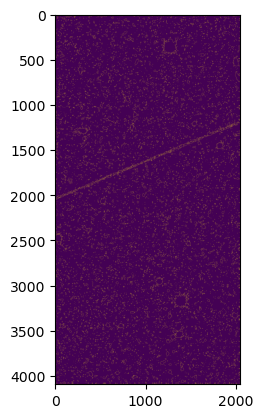

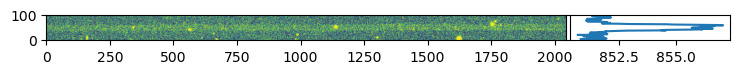

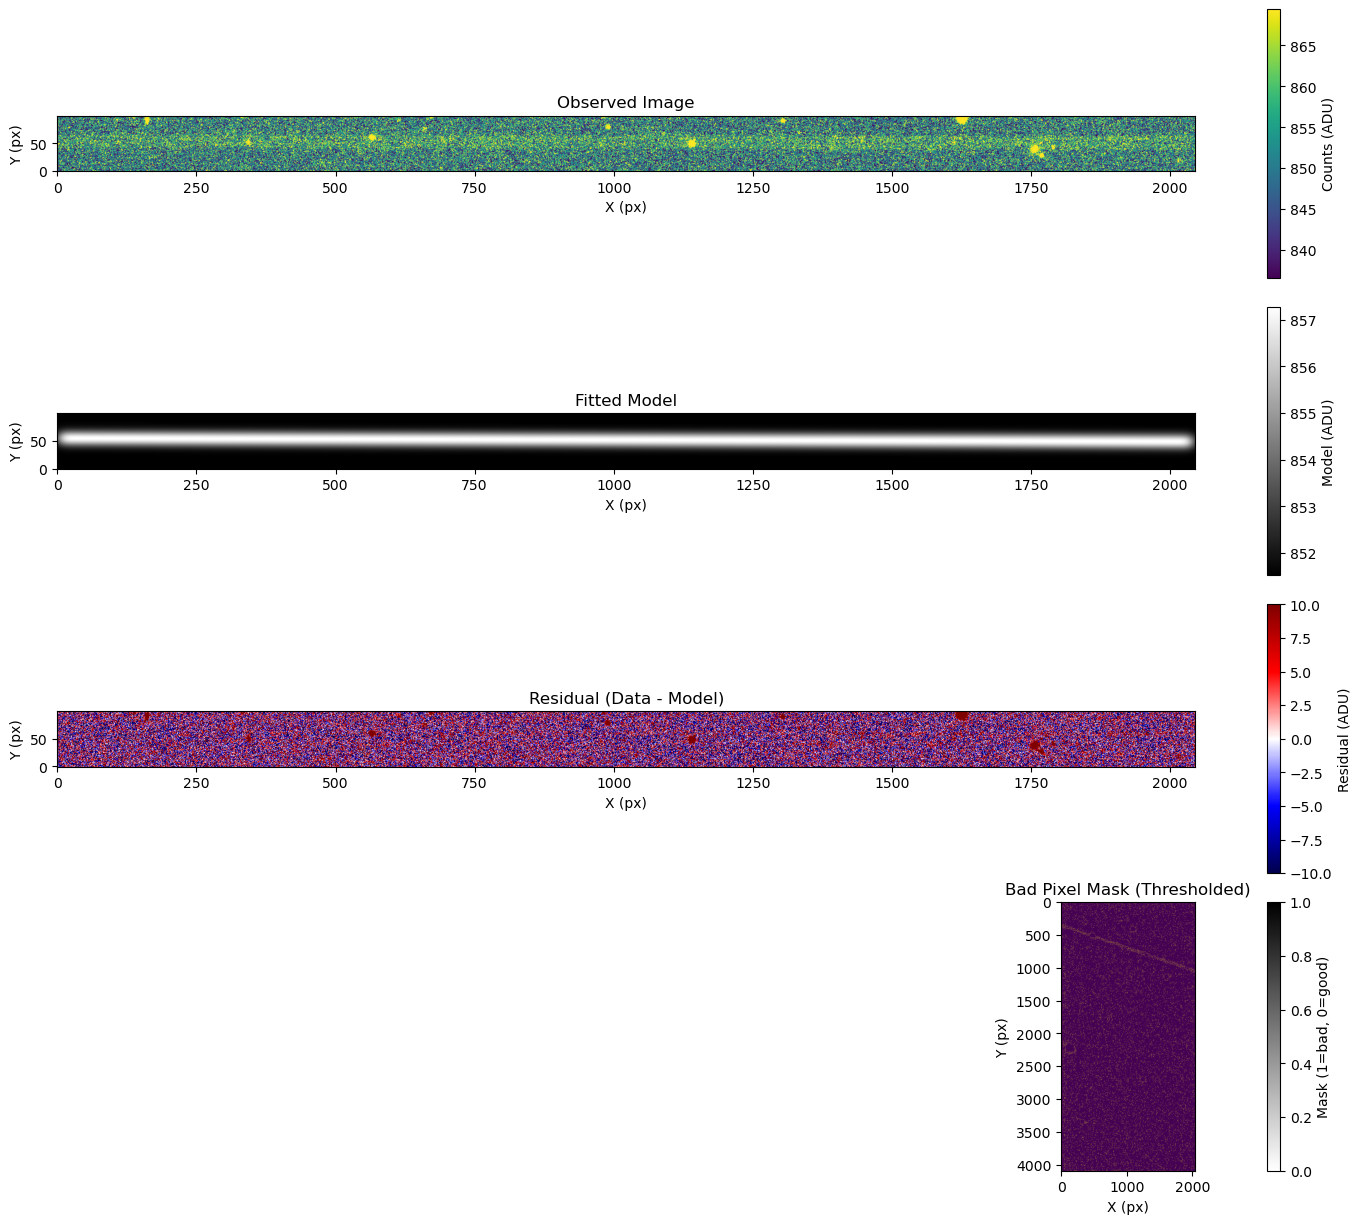

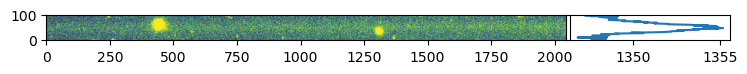

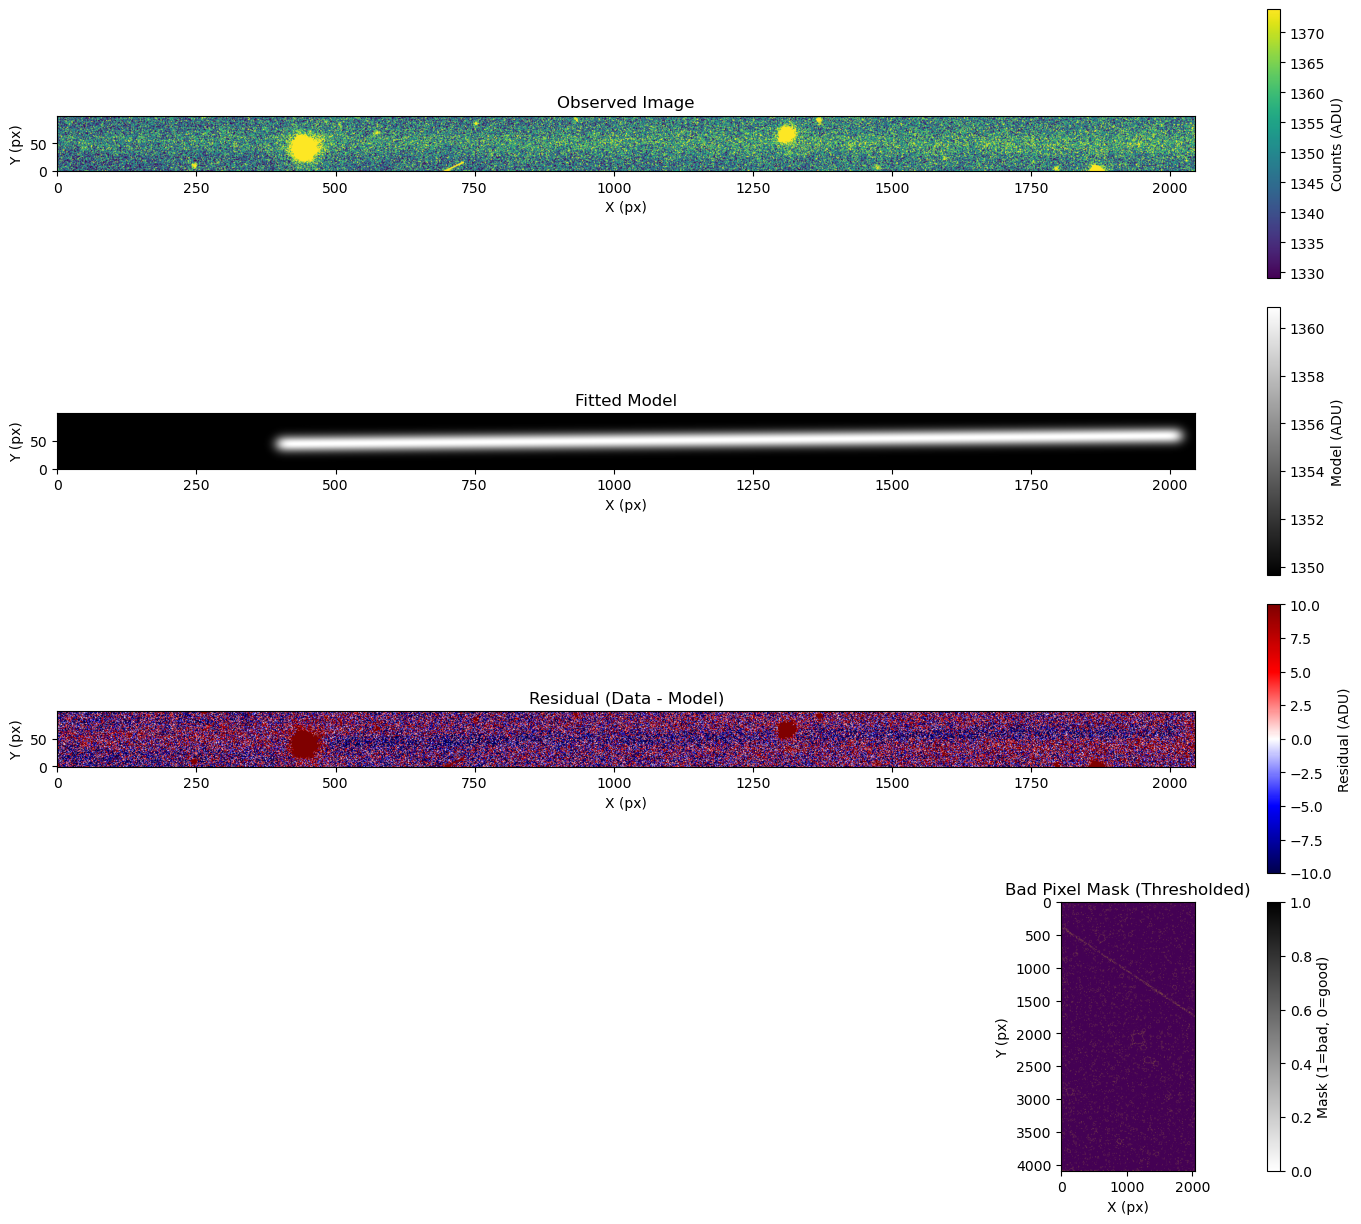

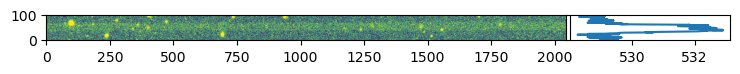

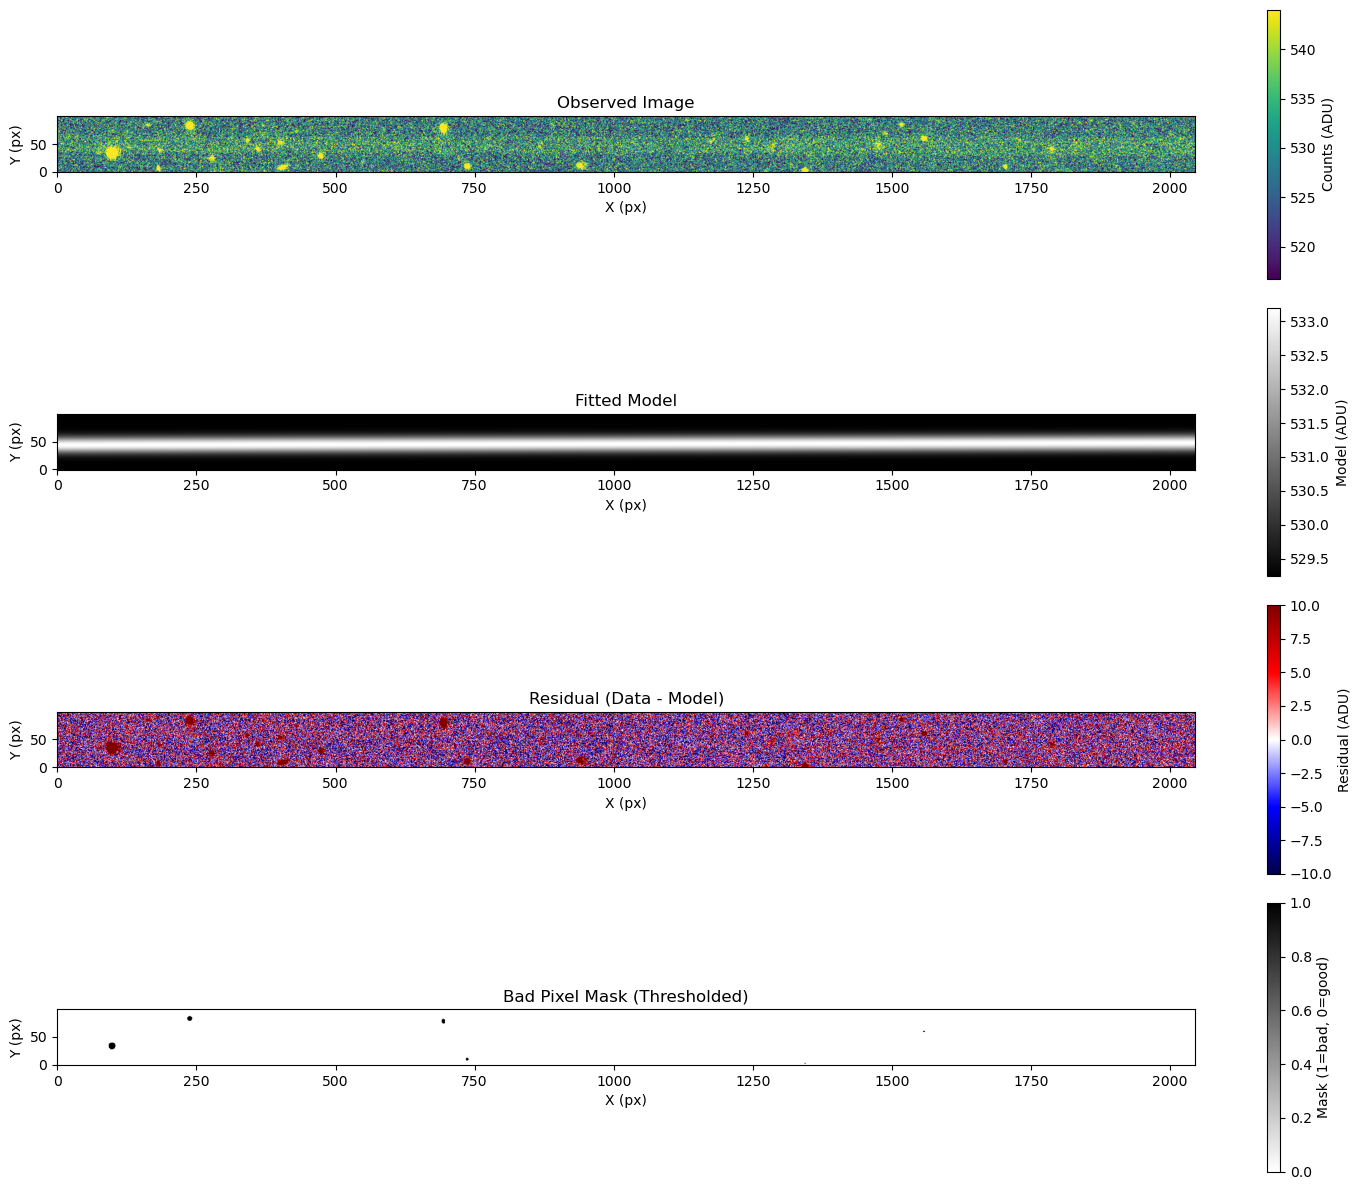

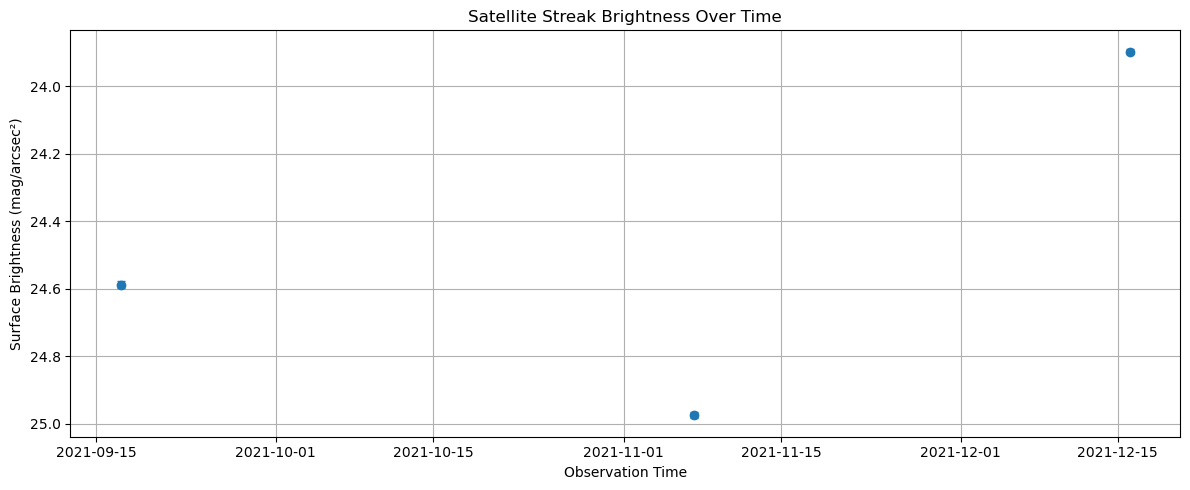

In [101]:
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages("all_streak_diagnostics.pdf")


# Step 1: Input data (selecting only the first detector when multiple are listed)
data = [
    ("2021-09-17 4:27:56", 1033925, 17),
    ("2021-12-16 1:10:37", 1061946, 18),
    ("2021-11-07 7:03:06", 1049047, 18),]

'''
    ("2022-09-15 8:19:02", 1134933, 5),
    ("2022-10-06 3:23:43", 1138498, 23),
    ("2022-01-16 5:14:50", 1072590, 5),
    ("2022-01-16 5:14:50", 1161471, 9),
    ("2022-09-04 4:38:47", 1129877, 51),
    ("2022-08-29 8:01:25", 1126795, 39),
    ("2021-04-14 23:54:44", 984831, 7),
    ("2021-04-14 23:54:44", 984831, 28),
    ("2021-11-26 7:43:17", 1054799, 38),
    ("2022-01-21 6:26:41", 1074544, 28),  # from "28 & 17"
    ("2023-04-01 0:02:03", 1189811, 26),
    ("2022-01-20 5:10:15", 1074073, 32),
    ("2023-01-24 3:31:24", 1166793, 45),
    ("2022-08-25 9:53:45", 1125268, 21),  # from "21 & 14"
]
'''

custom_params = {
    1033925: {"brightness_cuts": (3,5), "thresholding_cut": 0.08},
    1061946: {"brightness_cuts": (3,5), "thresholding_cut": 0.08},
    1049047: {"brightness_cuts": (3,5), "thresholding_cut": 0.06},
    # Add more as needed
}

df = pd.DataFrame(data, columns=["Time", "Expnum", "Detector"])
df["Time"] = pd.to_datetime(df["Time"])

# Step 2: Placeholder function call — loop over exposures
results = []


with PdfPages("all_streak_diagnostics.pdf") as pdf:

    for i, row in df.iterrows():
        expnum = int(row["Expnum"])
        detector = int(row["Detector"])
        time = row["Time"]
    
        print(f"\n Processing expnum {expnum}, detector {detector}, time {time}...")
    
        try:
            image_data, header, header_expnum = load_decam_image(expnum, detector)
            hough_kwargs = custom_params.get(expnum, {})
            print (hough_kwargs)
            rotated_image = get_rotated_streak_image(image_data, **hough_kwargs)
            results_photometry = streak_photometry_psf_fitting(rotated_image,
                                                                            header,
                                                                            header_expnum,
                                                                            pdf=pdf)
    
            results.append({
                "Time": time,
                "Expnum_Detector": f"{expnum}_{detector}",
                **results_photometry
            })
    
        except Exception as e:
            print(f" Error processing expnum {expnum}, detector {detector}: {e}")
            results.append({
                "Time": time,
                "Expnum_Detector": f"{expnum}_{detector}",
                **results_photometry
            })

# Step 3: Save results
results_df = pd.DataFrame(results)
results_df.to_csv("satellite_streak_brightness.csv", index=False)
print("\n Finished processing all exposures. Results saved to 'satellite_streak_brightness.csv'.")


# Time series of surface brightness in mag/arcsec²


df_clean = results_df[results_df["SB_mag"].apply(lambda x: isinstance(x, float))]
df_clean = df_clean.sort_values("Time")

plt.figure(figsize=(12,5))
plt.errorbar(df_clean["Time"], df_clean["SB_mag"], yerr=df_clean["SB_mag_err"], fmt='o', capsize=3)
plt.gca().invert_yaxis()
plt.xlabel("Observation Time")
plt.ylabel("Surface Brightness (mag/arcsec²)")
plt.title("Satellite Streak Brightness Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()



In [107]:
results_df

,Time,Expnum_Detector,SB_counts,SB_counts_err,SB_mag,SB_mag_err,Zeropoint,Background,Flux_total,Flux_err,Trail_Length_px,PSF_Sigma_px,PSF_FWHM_arcsec,Trail_angle_deg,Center_x0,Center_y0,SNR,Chi2,Chi2_red
0,2021-09-17 04:27:56,1033925_17,88.159325,1.484790,24.586829,0.011295,29.450,851.516861,274101.946978,4616.459154,2035.526507,9.3273,5.792379,0.168682,1021.256205,51.568312,96.125554,4704.053642,0.510256
1,2021-12-16 01:10:37,1061946_18,172.374149,3.515525,23.896820,0.008154,29.488,1349.625595,458315.213097,9347.216508,1623.607198,10.0000,6.210135,-0.523379,1207.326686,51.726262,133.151270,5016.958118,0.595061
2,2021-11-07 07:03:06,1049047_18,60.710254,5.199928,24.973845,0.009169,29.432,529.238121,266114.836487,22793.149888,2676.676403,10.0000,6.210135,-0.106728,986.256053,46.029033,118.408333,3917.961324,0.433739
